In [12]:
import pandas as pd
import numpy as np
import os, gzip

# Create a long form version of the birth data.
dl = []
for y in range(2011, 2021):
    da = pd.read_csv("%4d.txt" % y, delimiter="\t", dtype={"County Code": object})
    da = da[["County", "County Code", "Births"]]
    da["year"] = y
    dl.append(da)
print(dl)

[                   County County Code  Births  year
0      Baldwin County, AL       01003  2157.0  2011
1      Calhoun County, AL       01015  1418.0  2011
2       Etowah County, AL       01055  1173.0  2011
3    Jefferson County, AL       01073  8916.0  2011
4          Lee County, AL       01081  1536.0  2011
..                    ...         ...     ...   ...
624                   NaN         NaN     NaN  2011
625                   NaN         NaN     NaN  2011
626                   NaN         NaN     NaN  2011
627                   NaN         NaN     NaN  2011
628                   NaN         NaN     NaN  2011

[629 rows x 4 columns],                    County County Code  Births  year
0      Baldwin County, AL       01003  2109.0  2012
1      Calhoun County, AL       01015  1295.0  2012
2       Etowah County, AL       01055  1148.0  2012
3    Jefferson County, AL       01073  9027.0  2012
4          Lee County, AL       01081  1778.0  2012
..                    ...         ... 

In [13]:
births = pd.concat(dl)
births = births.rename({"County Code": "FIPS"}, axis=1)
births["Births"] = pd.to_numeric(births.Births, errors="coerce")
births = births.dropna()
births = births[~births["County"].str.contains("Unidentified")]
births

,County,FIPS,Births,year
0,"Baldwin County, AL",01003,2157.0,2011
1,"Calhoun County, AL",01015,1418.0,2011
2,"Etowah County, AL",01055,1173.0,2011
3,"Jefferson County, AL",01073,8916.0,2011
4,"Lee County, AL",01081,1536.0,2011
...,...,...,...,...
619,"Sheboygan County, WI",55117,1131.0,2020
620,"Walworth County, WI",55127,833.0,2020
621,"Washington County, WI",55131,1163.0,2020
622,"Waukesha County, WI",55133,3743.0,2020


In [14]:
# Read the demographics for 2016.  It is a fixed-width format file.
x = [1, 5, 7, 9, 12, 14, 15, 16, 17, 19, 27]
cs = [(x[i]-1, x[i+1]-1) for i in range(len(x)-1)]
with open("2016ages.txt") as io:
    demog = pd.read_fwf(io, colspecs=cs, header=None)
demog.columns = ["Year", "State", "StateFIPS", "CountyFIPS", "Registry",
                 "Race", "Origin", "Sex", "Age", "Population"]
# Create a FIPS code that matches the FIPS code in the birth data
demog["FIPS"] = ["%02d%03d" % (x, y) for (x, y) in zip(demog.StateFIPS, demog.CountyFIPS)]
demog = demog[["FIPS", "Race", "Origin", "Sex", "Age", "Population"]]
# Recode some variables to more interpretable text labels
# See http://seer.cancer.gov/popdata/popdic.html for code information
demog["Sex"] = demog["Sex"].replace([2, 1], ["F", "M"]) # Female/Male
demog["Origin"] = demog["Origin"].replace([0, 1], ["N", "H"]) # Non-Hispanic/Hispanic
demog["Race"] = demog["Race"].replace([1, 2, 3, 4], ["W", "B", "N", "A"]) # White/Black/Native/Asian
demog

,FIPS,Race,Origin,Sex,Age,Population
0,01001,W,N,M,0,238
1,01001,W,N,M,1,961
2,01001,W,N,M,2,1373
3,01001,W,N,M,3,1410
4,01001,W,N,M,4,1434
...,...,...,...,...,...,...
701769,56045,A,N,F,14,2
701770,56045,A,N,F,15,1
701771,56045,A,N,F,17,1
701772,56045,A,H,M,7,1


In [15]:
# The overall population per county
pop = demog.groupby("FIPS")["Population"].sum().reset_index()

# Pivot to put the age bands in the columns
demog = demog.pivot(index="FIPS", columns=["Race", "Origin", "Sex", "Age"], values="Population")

# Age group labels
age_groups = ["0", "1-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
              "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79",
              "80-84", "85+"]

na = demog.columns.tolist()
demog.columns = ["%s_%s_%s_%d" % tuple(x) for x in na]

# Replace missing demographic values with 0 and transform
# with square root to stabilize the variance.
demog = demog.fillna(0)
demog = np.sqrt(demog)

demog

,W_N_M_0,W_N_M_1,W_N_M_2,W_N_M_3,W_N_M_4,W_N_M_5,W_N_M_6,W_N_M_7,W_N_M_8,W_N_M_9,...,B_H_M_18,N_H_M_17,A_H_F_12,N_H_M_18,A_H_M_17,A_H_M_16,A_H_F_16,A_H_F_17,N_H_M_16,A_H_F_18
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,15.427249,31.000000,37.054015,37.549967,37.868192,34.899857,35.860842,35.256205,35.805028,37.175261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,30.265492,60.794737,70.199715,72.924619,71.021124,65.772335,67.764297,68.007353,70.413067,71.944423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,6.403124,14.071247,16.401219,16.462078,17.492856,19.000000,20.663978,19.773720,20.074860,21.142375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,10.392305,18.841444,22.561028,23.727621,23.216374,21.817424,23.937418,23.345235,23.643181,24.596748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,16.370706,33.630343,38.961519,39.166312,40.435133,37.894591,38.157568,36.701499,38.639358,39.217343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,15.427249,31.320920,36.262929,35.832946,34.669872,32.787193,35.846897,37.907783,37.322915,33.778692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56039,9.539392,18.894444,21.679483,20.760539,19.026298,19.442222,30.659419,30.430248,28.913665,27.982137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56041,11.704700,23.600847,28.089144,27.748874,26.172505,21.540659,22.203603,24.859606,24.939928,23.790755,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [16]:
# Get the Rural/Urban Continuity Codes (RUCC)
rucc = pd.read_excel('ruralurbancodes2013.xlsx', sheet_name="Rural-urban Continuum Code 2013")
rucc = rucc[["FIPS", "RUCC_2013"]]
rucc["FIPS"] = ["%05d" % x for x in rucc.FIPS]
rucc


,FIPS,RUCC_2013
0,01001,2.0
1,01003,3.0
2,01005,6.0
3,01007,1.0
4,01009,1.0
...,...,...
3229,72151,1.0
3230,72153,2.0
3231,78010,5.0
3232,78020,7.0


In [17]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a dataframe for modeling.  Merge the birth data with
# population and RUCC data.
da = pd.merge(births, pop, on="FIPS", how="left")
da = pd.merge(da, rucc, on="FIPS", how="left")

da["logPop"] = np.log(da["Population"])
da = da.dropna()
da = da.sort_values(["FIPS", "year"])

da["yearc"] = da["year"] - da["year"].mean()
da["logPopc"] = da["logPop"] - da["logPop"].mean()
da["RUCC_2013c"] = da["RUCC_2013"] - da["RUCC_2013"].mean()

pdf = PdfPages("pcr_py.pdf")


In [18]:
# Calculate the mean and variance within each county to
# assess the mean/variance relationship.
mv = births.groupby("FIPS")["Births"].agg([np.mean, np.var])
lmv = np.log(mv)

# Regress log variance on log mean
mr = sm.OLS.from_formula("var ~ mean", lmv).fit()
print(mr.summary())


                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2042.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):          7.38e-192
Time:                        00:55:10   Log-Likelihood:                -735.05
No. Observations:                 580   AIC:                             1474.
Df Residuals:                     578   BIC:                             1483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4898      0.338    -16.231      0.0

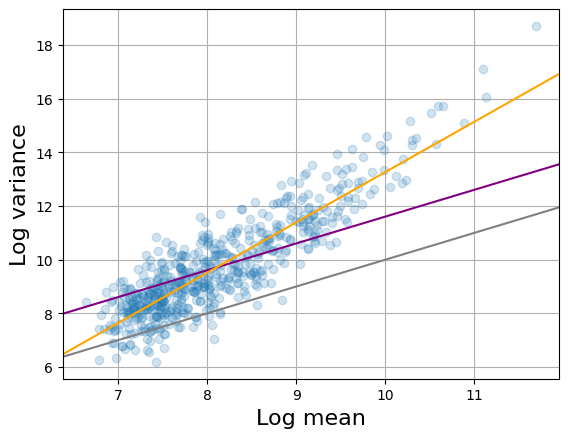

In [19]:
# Plot the log variance against the log mean.  If variance = phi*mean,
# then log(variance) = log(phi) + log(mean), i.e. the slope is 1 and
# the intercept is log(phi).
plt.clf()
plt.grid(True)
plt.plot(lmv["mean"], lmv["var"], "o", alpha=0.2, rasterized=True)
plt.axline((8, 8), slope=1, color="grey")
plt.axline((lmv["mean"].mean(0), lmv["var"].mean(0)), slope=1, color="purple")
plt.axline((8, mr.params[0]+8*mr.params[1]), slope=mr.params[1], color="orange")
plt.xlabel("Log mean", size=16)
plt.ylabel("Log variance", size=16)
pdf.savefig()  

In [20]:
# GLM, not appropriate since we have repeated measures on counties
fml = "Births ~ logPop + RUCC_2013"
m0 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r0 = m0.fit() # Poisson
r0x = m0.fit(scale="X2") # Quasi-Poisson
r0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5618
Model:                            GLM   Df Residuals:                     5615
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.9588e+05
Date:                Fri, 20 Oct 2023   Deviance:                   7.3576e+05
Time:                        00:55:14   Pearson chi2:                 7.47e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9151      0.003  -1611.426      0.000      -4.921      -4.909
logPop         1.0346      0.000   5138.178      0.000       1.034       1.035
RUCC_2013      0.0250      0.000     74.706      0.000       0.024       0.026
==============================================================================
"""

In [21]:
# GEE accounts for the correlated data
m1 = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Poisson(), data=da)
r1 = m1.fit() # Poisson and quasi-Poisson are the same for GEE
r1x = m1.fit(scale="X2")
r1x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 20 Oct 2023   Scale:                         133.052
Covariance type:                    robust   Time:                         00:55:16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9151      0.190    -25.833      0.000      -5.288      -4.542
logPop         1.0346      0.013     77.405      0.000       1.008       1.061
RUCC_2013      0.0250      0.014      1.842      0.065      -0.002       0.052
==============================================================================
Skew:                         -4.2707   Kurtosis:                     134.1520
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

In [22]:
# Use log population as an offset instead of a covariate
m2 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Poisson(), data=da)
r2 = m2.fit(scale="X2")
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 20 Oct 2023   Scale:                         137.859
Covariance type:                    robust   Time:                         00:55:18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3963      0.019   -232.699      0.000      -4.433      -4.359
RUCC_2013     -0.0095      0.010     -0.931      0.352      -0.030       0.011
==============================================================================
Skew:                          1.2162   Kurtosis:                      56.8103
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

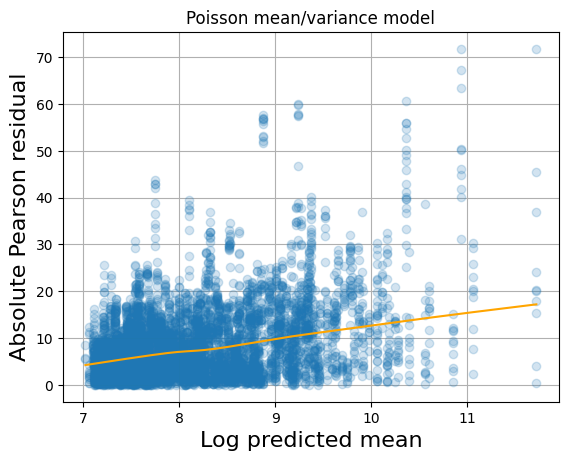

In [23]:
# A diagnostic plot for the variance structure that does not require
# there to be replicates.
plt.clf()
plt.grid(True)
lfv = np.log(r2.fittedvalues).values
apr = np.abs(r2.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Poisson mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)
pdf.savefig()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


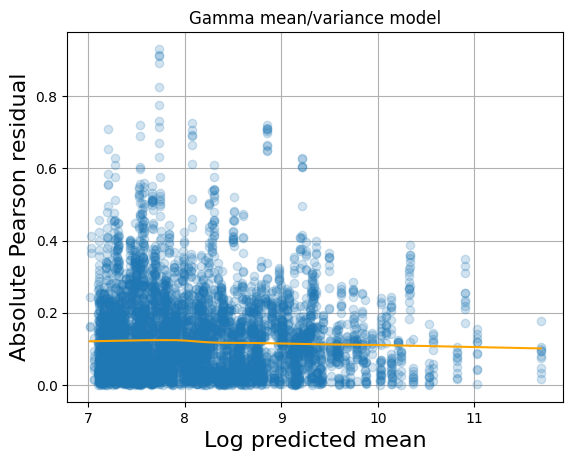

In [24]:
# Use Gamma family to better match the mean/variance relationship.
m3 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r3 = m3.fit(scale="X2")

# Diagnostic plot for mean/variance relationship with gamma model.
plt.clf()
plt.grid(True)
lfv = np.log(r3.fittedvalues).values
apr = np.abs(r3.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)
pdf.savefig()

In [25]:
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 20 Oct 2023   Scale:                           0.033
Covariance type:                    robust   Time:                         00:55:25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4436      0.015   -287.071      0.000      -4.474      -4.413
RUCC_2013      0.0031      0.008      0.388      0.698      -0.013       0.019
==============================================================================
Skew:                          3.3915   Kurtosis:                      46.1832
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

In [26]:
# Use exchangeable correlation structure.  Since RUCC is constant within
# groups the parameter estimates and standard errors are the same
# as with the independence model.
m4 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r4 = m4.fit(scale="X2")

m5 = sm.GEE.from_formula("Births ~ RUCC_2013 + year", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r5 = m5.fit(scale="X2")

m6 = sm.GEE.from_formula("Births ~ RUCC_2013c * yearc", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r6 = m6.fit(scale="X2")

print("Score tests:")
print(r5.model.compare_score_test(r4))
print(r6.model.compare_score_test(r5))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Score tests:
{'statistic': 181.8835449312546, 'df': 1, 'p-value': 0.0}
{'statistic': 26.534748710067415, 'df': 2, 'p-value': 1.7300255945595922e-06}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [27]:
# Get factors (principal components) from the demographic data
demog -= demog.mean(0)
u, s, vt = np.linalg.svd(demog)
v = vt.T

# Convert the coefficients back to the original coordinates
def convert_coef(c, npc):
    return np.dot(v[:, 0:npc], c/s[0:npc])

# The proportion of explained variance.
pve = s**2
pve /= sum(pve)

# Put the demographic factors into a dataframe
m = {("pc%02d" % k) : u[:, k] for k in range(100)}
m["FIPS"] = demog.index
demog_f = pd.DataFrame(m)

# Merge demographic information into the births data
da = pd.merge(da, demog_f, on="FIPS", how="left")

# Include this number of factors in subsequent models
npc = 50

# A GLM, not appropriate since we have repeated measures on counties
fml = "Births ~ (logPopc + RUCC_2013c) * yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
m7 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r7 = m7.fit(scale="X2")

# GEE accounts for the correlated data
m8 = sm.GEE.from_formula(fml, groups="FIPS",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r8 = m8.fit(scale="X2")

# Use log population as an offset instead of a covariate
fml = "Births ~ " + " + ".join(["pc%02d" % j for j in range(npc)])
m9 = sm.GEE.from_formula(fml, groups="FIPS", offset="logPop",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r9 = m9.fit(scale="X2")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [30]:
# Restructure the coefficients so that the age bands are
# in the columns.
def restructure(c):
    ii = pd.MultiIndex.from_tuples(na)
    c = pd.Series(c, index=ii)
    c = c.unstack()
    return c

# This function fits a Poisson GLM to the data using 'npc' principal components
# as explanatory variables.
def fitmodel(npc):
    # A GEE using log population as an offset
    fml = "Births ~ 1" if npc == 0 else "Births ~ RUCC_2013*year + " + " + ".join(["pc%02d" % j for j in range(npc)])
    m = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Gamma(link=sm.families.links.log()),
                            offset=da["logPop"], data=da)
    r = m.fit(scale="X2")

    # Convert the coefficients back to the original coordinates
    c = convert_coef(r.params[4:], npc)

    # Restructure the coefficients so that the age bands are
    # in the columns.
    c = restructure(c)

    return c, m, r

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias

<Figure size 640x480 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

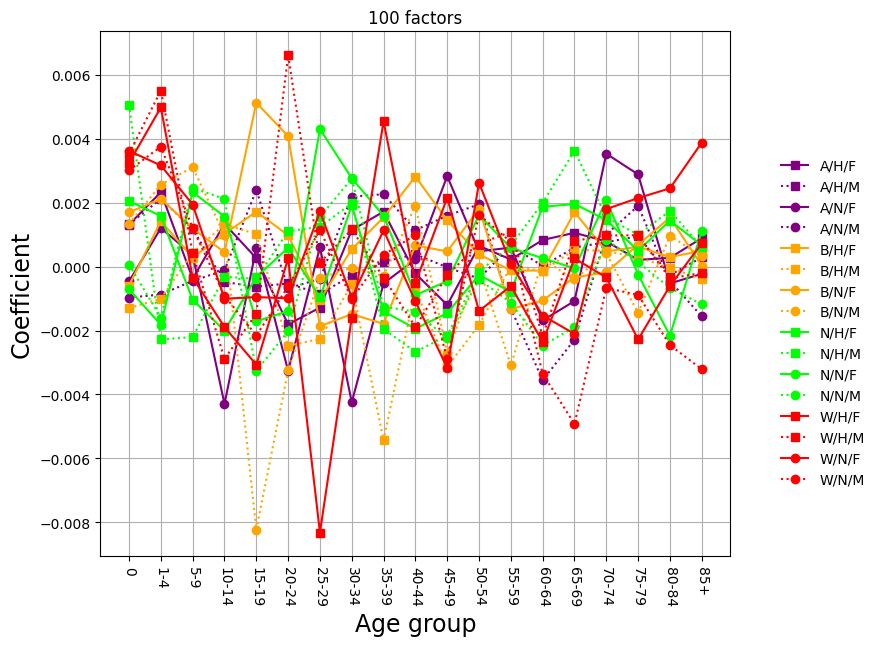

In [32]:
# Plot styling information
colors = {"A": "purple", "B": "orange", "N": "lime", "W": "red"}
lt = {"F": "-", "M": ":"}
sym = {"H": "s", "N": "o"}
ages = range(0, 19)

# Fit models with these numbers of PCs.
pcs = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

models = []
for npc in pcs:

    c, m, r = fitmodel(npc)
    models.append((m, r))

    plt.clf()
    plt.figure(figsize=(9, 7))
    ax = plt.axes([0.14, 0.18, 0.7, 0.75])
    ax.grid(True)
    for i in range(c.shape[0]):
        a = c.index[i]
        la = "/".join(a)
        ax.plot(ages, c.iloc[i, :], lt[a[2]] + sym[a[1]], color=colors[a[0]],
                label=la)

    # Setup the horizontal axis labels
    ax.set_xticks(ages)
    ax.set_xticklabels(age_groups)
    for x in plt.gca().get_xticklabels():
        x.set_rotation(-90)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.xlabel("Age group", size=17)
    plt.ylabel("Coefficient", size=17)
    plt.title("%d factors" % npc)
    pdf.savefig()

pdf.close()

In [33]:
# Use score tests to get a sense of the number of PC factors
# to include; also consider the PVEs calculated above.
print("Score tests for PC's:")
for k in range(10):
    st = models[k+1][0].compare_score_test(models[k][1])
    print("%d versus %d: p=%f" % (pcs[k+1], pcs[k], st["p-value"]))

Score tests for PC's:
5 versus 0: p=0.000000
10 versus 5: p=0.000000
20 versus 10: p=0.000000
30 versus 20: p=0.014568
40 versus 30: p=0.002248
50 versus 40: p=0.002294
60 versus 50: p=0.098068
70 versus 60: p=0.474152
80 versus 70: p=0.757857
90 versus 80: p=0.119066
